# Fourier feature extraction

In [1]:
import pathlib

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dataset import csv2numpy
from transforms import stft

## Dataset description

This dataset includes **time-series** data generated by **accelerometer** and **gyroscope sensors** (*attitude*, *gravity*, *userAcceleration*, and *rotationRate*). It is collected with an iPhone 6s kept in the **participant's front pocket** using SensingKit which collects information from Core Motion framework on iOS devices. All data collected in **50Hz sample rate**.
A total of 24 participants in a range of gender, age, weight, and height performed **6 activities** in 15 trials in the same environment and conditions: *downstairs*, *upstairs*, *walking*, *jogging*, *sitting*, and *standing*. With this dataset, we aim to look for personal attributes fingerprints in time-series of sensor data, i.e. attribute-specific patterns that can be used to infer gender or personality of the data subjects in addition to their activities.

For each participant, the study had been commenced by collecting their demographic (age and gender) and physically-related (height and weight) information. For each trial, the researcher set up the phone and gave it to the current participants, then the researcher stood in a corner. Then, the participant pressed the start button of Crowdsense app and put it in their trousers' front pocket and performed the specified activity. We asked them to do it as natural as possible, like their everyday life. At the end of each trial, they took the phone out of their pocket and pressed the stop button.

### Import the data

In [4]:
classes = {
    "dws": "down-stairs",
    "ups": "up-stairs",
    "wlk": "walk",
    "std": "standing",
    "sit": "sitting",
    "jog": "jogging"
}

features = [
    "attitude.roll",
    "attitude.pitch",
    "attitude.yaw",
    "gravity.x",
    "gravity.y",
    "gravity.z",
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z",
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z"
]

Use `pathlib` to read all CSV files, getting the sample's class from the containing directory:

In [5]:
data_root = pathlib.Path("motionsense-dataset")

samples_files = []

In [6]:
for csv in data_root.glob("**/*.csv"):
    class_ = str(csv.parent.stem)[:3]
    if class_ in classes.keys():
        samples_files.append([csv, class_])

Convert the CSV file into a numpy darray, where first dimension is time and second dimension is the "features" dimension:

In [7]:
i = 0
sample = csv2numpy(samples_files[i][0])

In [8]:
sample.shape

(814, 12)

^ the first sample has a length of 814, around 16 seconds.

### "STFT"

Now we will extract the magnitude of the Fourier transform in windows of 256 using our helper function `stft`:

In [9]:
sample_stft = stft(sample, 256, pad=False)

The result has an aditional dimension which corresponds to the windows:

In [10]:
sample_stft.shape

(3, 256, 12)

^ We obtain 3 windows because the signal is truncated

The first feature of the sample has the following shape:

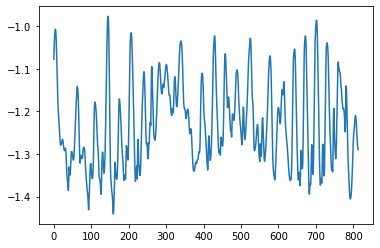

In [11]:
plt.plot(sample[:,1])

The corresponding transformed windows:

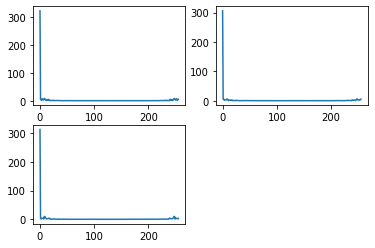

In [12]:
for i in range(sample_stft.shape[0]):
    plt.subplot(220 + i + 1)
    plt.plot(sample_stft[i,:,1])

At a first glance, they have a similar spectral density.

A posible feature extractor could be the mean spectral density (actualy the first half) over the windows:

In [13]:
sample_feats = np.mean(sample_stft, axis=0)[:128]

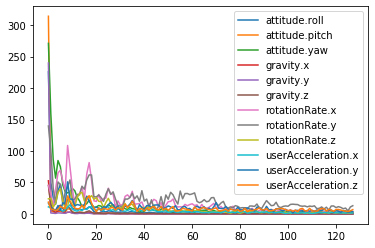

In [14]:
plt.plot(sample_feats)
plt.legend(features);

### Features discriminability

Now we will do the plots separately for each class.

In [15]:
feats_by_class = {"dws": [], "ups": [], "wlk": [], "std": [], "sit": [], "jog": []}

for file_, class_ in samples_files:
    sample = csv2numpy(file_)
    feats = np.mean(stft(sample, 256, pad=False), axis=0)[:128]
    feats_by_class[class_].append(feats)

#### Small parenthesis

With the created dictionary we can get the number of samples for each class:

In [16]:
for class_ in feats_by_class:
    print(f"Number of samples in class {classes[class_]}: {len(feats_by_class[class_])}")

Number of samples in class down-stairs: 72
Number of samples in class up-stairs: 72
Number of samples in class walk: 72
Number of samples in class standing: 48
Number of samples in class sitting: 48
Number of samples in class jogging: 48


Now lets plot the different features for each class.

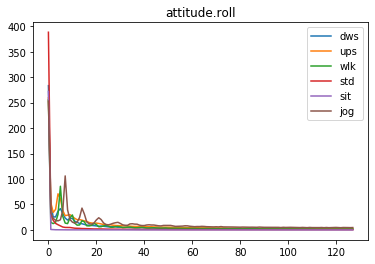

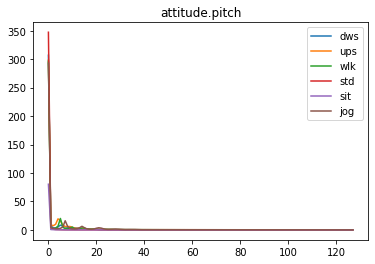

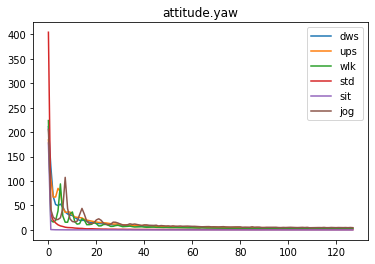

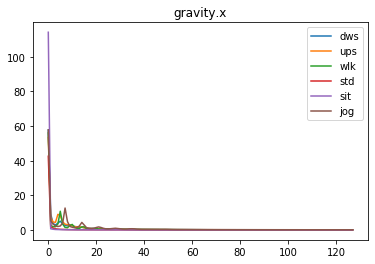

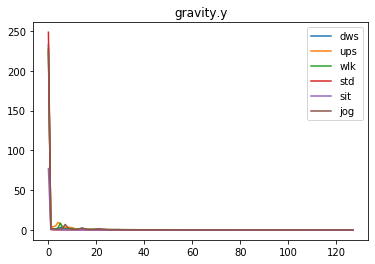

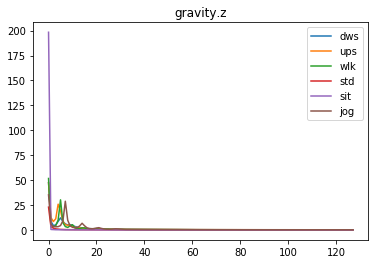

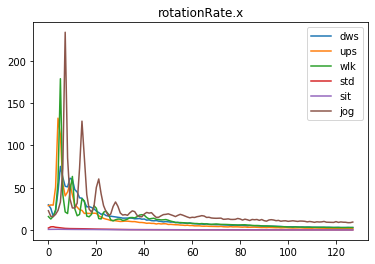

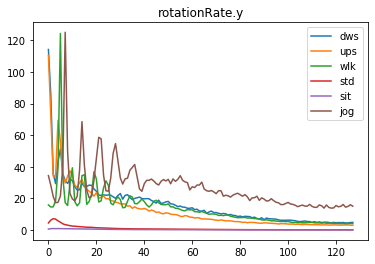

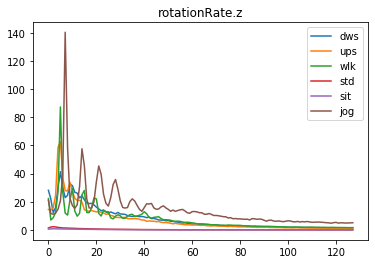

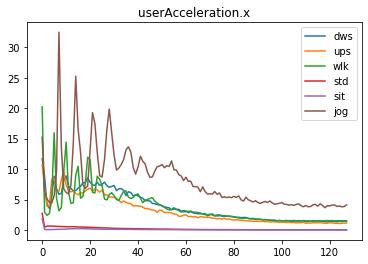

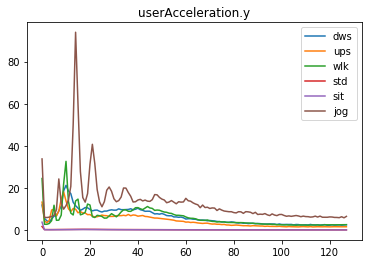

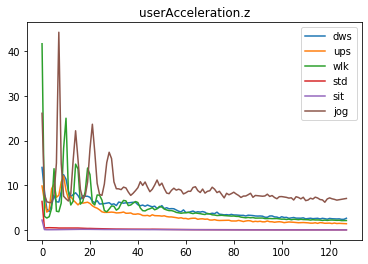

In [17]:
for i, feature in enumerate(features):
    plt.figure()
    plt.title(feature)
    for class_ in feats_by_class:
        plt.plot(np.mean(feats_by_class[class_], axis=0)[:, i], label=class_)
    plt.legend()

Based on the mean values, some classes look like could be easily discriminated from other. Now we should evaluate how much variability there is.